In [486]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
import shap

In [487]:
parts_data = pd.read_csv('/Users/skylerwilson/Desktop/Lighthouse_Labs/Projects/final_project/data/Project_Data/final_parts_data.csv')

In [488]:
# Clean sales data function
def clean_sales_data(df, column_names):
    for col in column_names:  
        df[col] = np.abs(df[col])
    return df

# Clean quantity data function
def clean_quantity_data(df, quantity_col):
    return df[df[quantity_col] > 0]

# Clean turnover data function
def clean_negative_data(df, turnover_col):
    return df[df[turnover_col] >= 0]


def z_score(column, threshold=2):
    z_scores = (column - column.mean()) / column.std()
    return np.abs(z_scores) < threshold

sales_data = ['Sales Last Month', 'Sales Last 3 Months', 'Sales Last 6 Months', 'Sales Last 9 Months',
              'Sales Last 12 Months', 'Sales Last 2 Years', 'Sales Last 3 Years',
              'Sales Last 4 Years', 'Sales Last 5 Years', 'Sales Last 10 Years',
              'Months No Sale', 'Reorder Point', 'Sales - Jan', 'Sales - Feb',
              'Sales - Mar', 'Sales - Apr', 'Sales - May', 'Sales - Jun',
              'Sales - Jul', 'Sales - Aug', 'Sales - Sep', 'Sales - Oct',
              'Sales - Nov', 'Sales - Dec', 'Sales - 1st Qtr', 'Sales - 2nd Qtr',
              'Sales - 3rd Qtr', 'Sales - 4th Qtr', 'Sales - This Year','Sales - Last Year']
quantity_col = 'Quantity'
turnover_col = 'Turnover'

num_cols = parts_data.select_dtypes(include='number').columns

# Apply preprocessing steps
parts_data = clean_sales_data(parts_data, sales_data)
parts_data = clean_quantity_data(parts_data, quantity_col)
parts_data = clean_negative_data(parts_data, turnover_col)


# Apply z-score transformation to numerical columns
parts_data[num_cols] = parts_data[parts_data[num_cols].apply(z_score)][num_cols]

#deals with columns that dont have data yet so they end up as NaN when they shouldnt
parts_data[num_cols] = np.where(parts_data[num_cols].isna(), 0, parts_data[num_cols])

In [489]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import randint, uniform

# Custom transformer classes
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        transformed_data = X.copy()
        for col in self.columns:
            transformed_data[col], _ = yeojohnson(X[col] + 0.01)  # Adding 0.01 to avoid zero values
        return transformed_data

# Load and preprocess the data
y = parts_data['Obsolete']
X = parts_data.select_dtypes(include='number').drop(columns=['Obsolete'])
constant_columns = X.columns[X.nunique() == 1]
X.drop(columns=constant_columns, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Define columns to transform
cols_to_transform = X.columns

# Column transformer for Yeo-Johnson transformation
yeo_johnson_cols = ColumnTransformer(
    transformers=[('yeo_johnson', YeoJohnsonTransformer(columns=cols_to_transform), cols_to_transform)],
    remainder='passthrough'
)

# Create FeatureUnion combining TruncatedSVD and SelectKBest
features = FeatureUnion([
    ('svd', TruncatedSVD(n_components=4)),
    ('select_k_best', SelectKBest(score_func=f_regression, k=6))
])


# Define your pipeline with the best parameters
final_pipeline = Pipeline([
    ('transformer', yeo_johnson_cols), 
    ('features', features),
    ('scaler', RobustScaler())
])

# Fit the pipeline to your training data
final_pipeline.fit(X_train, y_train)
 
       
X_train_transformed = final_pipeline.named_steps['transformer'].transform(X_train)
X_train_transformed = final_pipeline.named_steps['features'].transform(X_train_transformed)
X_train_transformed = final_pipeline.named_steps['scaler'].transform(X_train_transformed)

# Create a DataFrame with transformed and non-transformed data
X_train_transformed_df = pd.DataFrame(
    np.hstack((X_train_transformed, X_train.drop(columns=cols_to_transform))),
    columns=final_pipeline.named_steps['features'].get_feature_names_out(input_features=X_train.columns),
    index=X_train.index
)

# Transform the testing data using the pipeline
X_test_transformed = final_pipeline.named_steps['transformer'].transform(X_test)
X_test_transformed = final_pipeline.named_steps['features'].transform(X_test_transformed)
X_test_transformed = final_pipeline.named_steps['scaler'].transform(X_test_transformed)

# Create a DataFrame with transformed and non-transformed data for the testing set
X_test_transformed_df = pd.DataFrame(
    np.hstack((X_test_transformed, X_test.drop(columns=cols_to_transform))),
    columns=final_pipeline.named_steps['features'].get_feature_names_out(input_features=X_test.columns),
    index=X_test.index
)

#fit the model
clf = XGBClassifier(
    colsample_bytree=0.7,
    gamma=0.4,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=5,
    reg_alpha=0.6,
    reg_lambda=0.9,
    subsample=0.8,
    early_stopping_rounds=20

)
clf.fit(X_train_transformed, y_train, 
        eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)])

y_pred = clf.predict(X_test_transformed)
y_prob = clf.predict_proba(X_test_transformed)


[0]	validation_0-logloss:0.59900	validation_1-logloss:0.59927
[1]	validation_0-logloss:0.52182	validation_1-logloss:0.52234
[2]	validation_0-logloss:0.47309	validation_1-logloss:0.47448
[3]	validation_0-logloss:0.41635	validation_1-logloss:0.41768
[4]	validation_0-logloss:0.36793	validation_1-logloss:0.36922
[5]	validation_0-logloss:0.32636	validation_1-logloss:0.32761
[6]	validation_0-logloss:0.29035	validation_1-logloss:0.29158
[7]	validation_0-logloss:0.25934	validation_1-logloss:0.26058
[8]	validation_0-logloss:0.23219	validation_1-logloss:0.23341
[9]	validation_0-logloss:0.21474	validation_1-logloss:0.21637
[10]	validation_0-logloss:0.19294	validation_1-logloss:0.19457
[11]	validation_0-logloss:0.17364	validation_1-logloss:0.17524
[12]	validation_0-logloss:0.15658	validation_1-logloss:0.15815
[13]	validation_0-logloss:0.14142	validation_1-logloss:0.14296
[14]	validation_0-logloss:0.12796	validation_1-logloss:0.12952
[15]	validation_0-logloss:0.11952	validation_1-logloss:0.12120
[1

In [490]:
print('------------------------------------------------------')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print('------------------------------------------------------')
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)
print('------------------------------------------------------')
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob[:, 1])}")
print('------------------------------------------------------')
print(f'Average Percision & Recall Score: {average_precision_score(y_test, y_prob[:,1])}')

------------------------------------------------------
Accuracy Score: 0.9980713596914176
------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2301
         1.0       0.99      1.00      1.00       810

    accuracy                           1.00      3111
   macro avg       1.00      1.00      1.00      3111
weighted avg       1.00      1.00      1.00      3111

------------------------------------------------------
ROC-AUC Score: 0.9998932294600844
------------------------------------------------------
Average Percision & Recall Score: 0.999689401003765


In [491]:
# Create the prediction_data DataFrame with the preserved index
prediction_data = pd.DataFrame({
    'PartIndex': X_test.index,
    'Obsolete Prediction': y_pred,
    'Obsolete Probability %': y_prob[:, 1] * 100
})

# Merge data using the PartIndex as the key
merged_data = prediction_data.merge(
    X_test_transformed_df,
    left_on='PartIndex',
    right_index=True,
    how='left'
)

# Merge with additional columns from parts_data
merged_data = merged_data.merge(
    parts_data[['Part Number', 'Supplier Name', 'Description', 'Price', 'Quantity', 'Margin %', 'Total Cost', 'Months No Sale', 'Quantity Ordered YTD', 'Turnover', 'EOQ', 'Customer LTV']],
    left_on='PartIndex',
    right_index=True,
    how='left'
)

# Drop rows with missing data
obsolete_parts_with_probabilities = merged_data.dropna(subset=['Supplier Name', 'Description', 'Obsolete Probability %'])


In [492]:
obsolete_parts_with_probabilities.columns

Index(['PartIndex', 'Obsolete Prediction', 'Obsolete Probability %',
       'svd__truncatedsvd0', 'svd__truncatedsvd1', 'svd__truncatedsvd2',
       'svd__truncatedsvd3', 'select_k_best__Sales Last 9 Months',
       'select_k_best__Sales Last 12 Months', 'select_k_best__Months No Sale',
       'select_k_best__Carrying Cost', 'select_k_best__Total Score',
       'select_k_best__Customer LTV', 'Part Number', 'Supplier Name',
       'Description', 'Price', 'Quantity', 'Margin %', 'Total Cost',
       'Months No Sale', 'Quantity Ordered YTD', 'Turnover', 'EOQ',
       'Customer LTV'],
      dtype='object')

In [493]:
cols_to_drop = ['svd__truncatedsvd0', 'svd__truncatedsvd1', 'svd__truncatedsvd2',
       'select_k_best__Months No Sale', 'select_k_best__Carrying Cost',
       'select_k_best__Customer LTV','PartIndex']

obsolete_parts_with_probabilities.drop(columns=cols_to_drop, inplace=True)

In [494]:
import plotly.express as px
# Create an interactive scatter plot using Plotly Express
fig = px.scatter(
    obsolete_parts_with_probabilities,
    x='Obsolete Probability %',
    y='Price',
    color='Margin %',
    hover_name='Part Number',
    hover_data = ['Description', 'Supplier Name', 'Months No Sale', 'Turnover', 'EOQ'],
    title='Interactive Scatterplot of Obsolete Probability Relative to Price',
    labels={'Obsolete Probability %': 'Obsolete Probability %', 'Price': 'Price'},
    template='plotly'  # Use the 'plotly' template for better interactivity
)

fig.show()

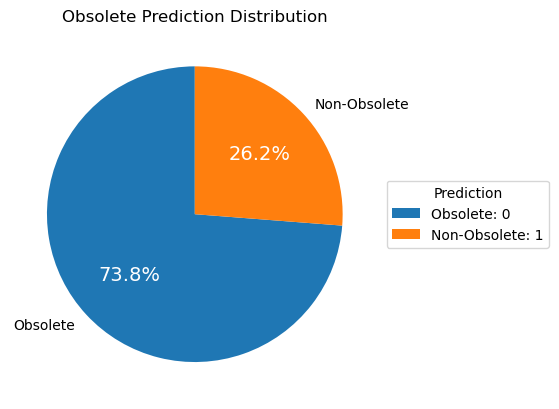

In [495]:
import matplotlib.pyplot as plt

# Calculate the value counts and percentages
obsolete_calc = obsolete_parts_with_probabilities['Obsolete Prediction'].value_counts() / len(obsolete_parts_with_probabilities) * 100

# Create custom labels for the pie chart slices
custom_labels = {'Obsolete': 0, 'Non-Obsolete': 1}

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(obsolete_calc.values, labels=custom_labels.keys(), autopct='%1.1f%%', startangle=90)

# Customize the text inside the chart slices
for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_color('white')

# Customize the legend
legend_labels = [f'{label}: {custom_labels[label]}' for label in custom_labels]
ax.legend(wedges, legend_labels, title='Prediction', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

# Set aspect ratio to be equal, so the pie is circular
ax.set_aspect('equal')

# Set title
plt.title('Obsolete Prediction Distribution')

# Show the interactive plot
plt.show()
